<a href="https://colab.research.google.com/github/AnnaBujniewicz/Masters_thesis/blob/main/6_Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://kernc.github.io/backtesting.py/doc/examples/Parameter%20Heatmap%20&%20Optimization.html

https://colab.research.google.com/github/kernc/backtesting.py/blob/master/doc/examples/Strategies%20Library.ipynb#scrollTo=X-FFXCnXIbO1

https://kernc.github.io/backtesting.py/doc/backtesting/#gsc.tab=0

https://github.com/kernc/backtesting.py

https://colab.research.google.com/github/kernc/backtesting.py/blob/master/doc/examples/Quick%20Start%20User%20Guide.ipynb#scrollTo=mSJIpLZKIauf

https://colab.research.google.com/github/kernc/backtesting.py/blob/master/doc/examples/Parameter%20Heatmap%20%26%20Optimization.ipynb

https://colab.research.google.com/github/kernc/backtesting.py/blob/master/doc/examples/Multiple%20Time%20Frames.ipynb#scrollTo=rMs8WvoxIZc6

https://colab.research.google.com/github/kernc/backtesting.py/blob/master/doc/examples/Trading%20with%20Machine%20Learning.ipynb

https://colab.research.google.com/github/kernc/backtesting.py/

https://algotrading101.com/learn/backtrader-for-backtesting/

# Initial Steps

In [ ]:
#istall necessary packages
! pip install ta > /dev/null
! pip install yfinance > /dev/null 2>&1
! mkdir hist > /dev/null
! pip install backtrader[plotting] > /dev/null
! pip install scikit-optimize  > /dev/null # This is a run-time dependency
! pip install backtesting  > /dev/null
! pip install mplfinance > /dev/null
! pip install backtrader > /dev/null

In [ ]:
# Load packages
from datetime import datetime
import backtrader as bt
import backtrader.analyzer as btanalyzers
import socket
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import os, contextlib
import warnings
warnings.filterwarnings('ignore')
from backtesting.test import SMA
import mplfinance as mpl
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting import Backtest
from google.colab import files

In [ ]:
backtest_results = pd.DataFrame(index = ['total_change_text_roi', 'total_change_tech_roi', 'total_change_both_roi', 'total_perc_change_text_roi', 'total_perc_change_tech_roi', 'total_perc_change_both_roi', 'bh_roi', 'sma_roi', 'dou_roi'])

In [ ]:
ticker =  "fox"

# Start loop

## Get the data

In [ ]:
plt.style.use('fivethirtyeight')

In [ ]:
#load hourly stock prices
df = yf.download(ticker.upper(),start='2021-01-18', 
                      end='2021-01-30', 
                      interval = '1h',
                 progress = False) 

In [ ]:
#visualization for the data
mpl.plot(df ,type="candle",volume=True, mav=(5,10), tight_layout=True, style="yahoo", show_nontrading=True, savefig='{}_prices_1.png'.format(ticker))

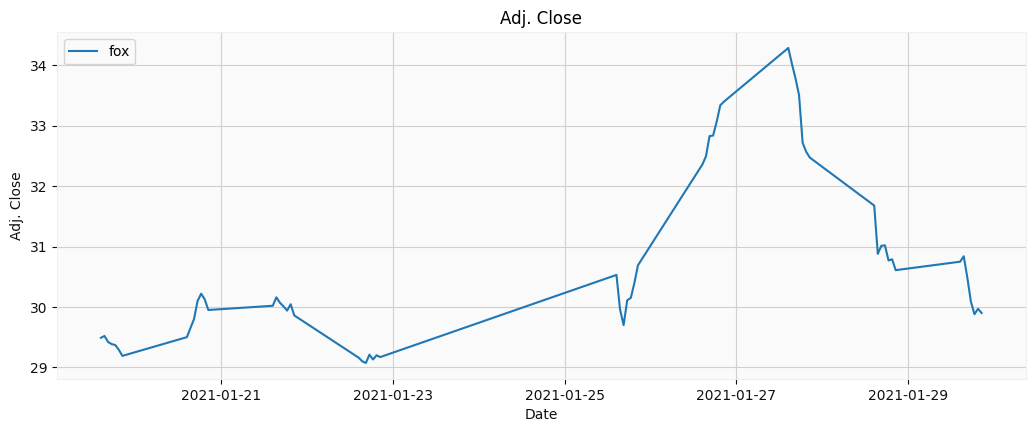

In [ ]:
#2nd visualization
plt.figure(figsize=(12.5,4.5))
plt.plot(df['Adj Close'], label=ticker)
plt.title('Adj. Close')
plt.xlabel('Date')
plt.ylabel('Adj. Close')
plt.legend(loc='upper left')
plt.savefig('{}_prices_2.png'.format(ticker))
plt.show()

##Simple Moving Average Strategy

In [ ]:
#creat a command
def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

In [ ]:
#creating the strategy with different moving average lags for optimization
class SmaCross(Strategy):
    n1 = 10
    n2 = 20
    
    def init(self):
        # create MA
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
 #creating a buy and sell signal 
    def next(self):
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()

In [ ]:
#%%script echo
# buy and sell command
def next(self):
    if (self.sma1[-2] < self.sma2[-2] and
                self.sma1[-1] > self.sma2[-1]):
      self.position.close()
      self.buy()

    elif (self.sma1[-2] > self.sma2[-2] and    
              self.sma1[-1] < self.sma2[-1]):
            self.position.close()
            self.sell()

###Backtest SMA

In [ ]:
#execute buy and sell commands with a predetermined cash and counting in costs
bt_simple = Backtest(df, SmaCross, cash=10_000, commission=.002)
stats_simple = bt_simple.run()
stats_simple

Start                     2021-01-19 09:30...
End                       2021-01-29 15:30...
Duration                     10 days 06:00:00
Exposure Time [%]                     60.3175
Equity Final [$]                      10066.7
Equity Peak [$]                       10785.4
Return [%]                           0.666829
Buy & Hold Return [%]                  1.3903
Return (Ann.) [%]                     20.4533
Volatility (Ann.) [%]                 85.2884
Sharpe Ratio                         0.239814
Sortino Ratio                        0.651036
Calmar Ratio                          2.06023
Max. Drawdown [%]                     -9.9277
Avg. Drawdown [%]                    -7.35698
Max. Drawdown Duration        3 days 20:00:00
Avg. Drawdown Duration        3 days 01:00:00
# Trades                                    3
Win Rate [%]                          66.6667
Best Trade [%]                        3.19239
Worst Trade [%]                      -4.21253
Avg. Trade [%]                    

In [ ]:
#visualization of the backtest
bt_simple.plot(filename='{}_sma_not_opt'.format(ticker))

###Optimization

In [ ]:
%%time
# Optimize the strategy
stats_simple = bt_simple.optimize(n1=range(5, 30, 5),
                    n2=range(10, 70, 5),
                    maximize='Equity Final [$]',
                    constraint=lambda param: param.n1 < param.n2)
stats_simple

CPU times: user 144 ms, sys: 43.5 ms, total: 187 ms
Wall time: 2.18 s


In [ ]:
#5 and 35 period seemd tho give the best results
stats_simple._strategy

<Strategy SmaCross(n1=5,n2=10)>

In [ ]:
#vsualize the optimized SMA strategy
bt_simple.plot(plot_volume=False, plot_pl=False, filename='{}_sma_opt'.format(ticker))

In [ ]:
stats_simple

Start                     2021-01-19 09:30...
End                       2021-01-29 15:30...
Duration                     10 days 06:00:00
Exposure Time [%]                      68.254
Equity Final [$]                      11257.3
Equity Peak [$]                       11282.9
Return [%]                            12.5726
Buy & Hold Return [%]                  1.3903
Return (Ann.) [%]                     2654.95
Volatility (Ann.) [%]                 2017.59
Sharpe Ratio                           1.3159
Sortino Ratio                         98.9928
Calmar Ratio                          354.878
Max. Drawdown [%]                    -7.48129
Avg. Drawdown [%]                    -2.69378
Max. Drawdown Duration        3 days 22:00:00
Avg. Drawdown Duration        1 days 06:00:00
# Trades                                    3
Win Rate [%]                          66.6667
Best Trade [%]                        7.80087
Worst Trade [%]                      -1.86874
Avg. Trade [%]                    

In [ ]:
stats_simple.tail()

Expectancy [%]                                              4.12282
SQN                                                         1.36333
_strategy                                      SmaCross(n1=5,n2=10)
_equity_curve                                      Equity  Drawd...
_trades              Size  EntryBar  ...                  ExitTi...
dtype: object

In [ ]:
stats_simple['_equity_curve']

,Equity,DrawdownPct,DrawdownDuration
2021-01-19 09:30:00-05:00,10000.000000,0.000000,NaT
2021-01-19 10:30:00-05:00,10000.000000,0.000000,NaT
2021-01-19 11:30:00-05:00,10000.000000,0.000000,NaT
2021-01-19 12:30:00-05:00,10000.000000,0.000000,NaT
2021-01-19 13:30:00-05:00,10000.000000,0.000000,NaT
...,...,...,...
2021-01-29 11:30:00-05:00,11087.128032,0.000000,0 days 20:00:00
2021-01-29 12:30:00-05:00,11215.527910,0.000000,NaT
2021-01-29 13:30:00-05:00,11282.938228,0.000000,NaT
2021-01-29 14:30:00-05:00,11254.048179,0.002561,NaT


In [ ]:
#show the individual trades
stats_simple['_trades'] 

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,-333,20,29,29.969941,30.530001,-186.499980,-0.018687,2021-01-21 15:30:00-05:00,2021-01-25 10:30:00-05:00,3 days 19:00:00
1,320,29,48,30.591061,32.560001,630.061019,0.064363,2021-01-25 10:30:00-05:00,2021-01-27 15:30:00-05:00,2 days 05:00:00
2,-321,48,62,32.494881,29.959999,813.697214,0.078009,2021-01-27 15:30:00-05:00,2021-01-29 15:30:00-05:00,2 days 00:00:00


In [ ]:
sma_roi = (list(stats_simple['_equity_curve'].Equity)[-1]/list(stats_simple['_equity_curve'].Equity)[0])-1

##Dou Mooving Average Strategy

https://github.com/rbhatia46/Dual-Moving-Average-Crossover-Python/blob/master/Dual-Moving-Average-Crossover-Python.ipynb


to deteman when to buy and sel a stock When a short term average crosses a long term average its shows that the momentum is shifting so buy signal is generating when the short term average rises above the long term average and a sell signal is generated when the short term and long term average crosses and falling under it.

https://www.youtube.com/watch?v=SEQbb8w7VTw&ab_channel=ComputerScience

In [ ]:
#create a simple mooving average with a short window
window1 = 5
sma1 = pd.DataFrame()
sma1['Adj Close'] = df['Adj Close'].rolling(window = window1).mean()
sma1

,Adj Close
2021-01-19 09:30:00-05:00,NaN
2021-01-19 10:30:00-05:00,NaN
2021-01-19 11:30:00-05:00,NaN
2021-01-19 12:30:00-05:00,NaN
2021-01-19 13:30:00-05:00,29.437
...,...
2021-01-29 11:30:00-05:00,30.696
2021-01-29 12:30:00-05:00,30.556
2021-01-29 13:30:00-05:00,30.410
2021-01-29 14:30:00-05:00,30.254


In [ ]:
#Creat a simple moving avarage long window
window2 = 35
sma2 = pd.DataFrame()
sma2['Adj Close'] = df['Adj Close'].rolling(window = window2).mean()
sma2

,Adj Close
2021-01-19 09:30:00-05:00,NaN
2021-01-19 10:30:00-05:00,NaN
2021-01-19 11:30:00-05:00,NaN
2021-01-19 12:30:00-05:00,NaN
2021-01-19 13:30:00-05:00,NaN
...,...
2021-01-29 11:30:00-05:00,31.451743
2021-01-29 12:30:00-05:00,31.476886
2021-01-29 13:30:00-05:00,31.498314
2021-01-29 14:30:00-05:00,31.520314


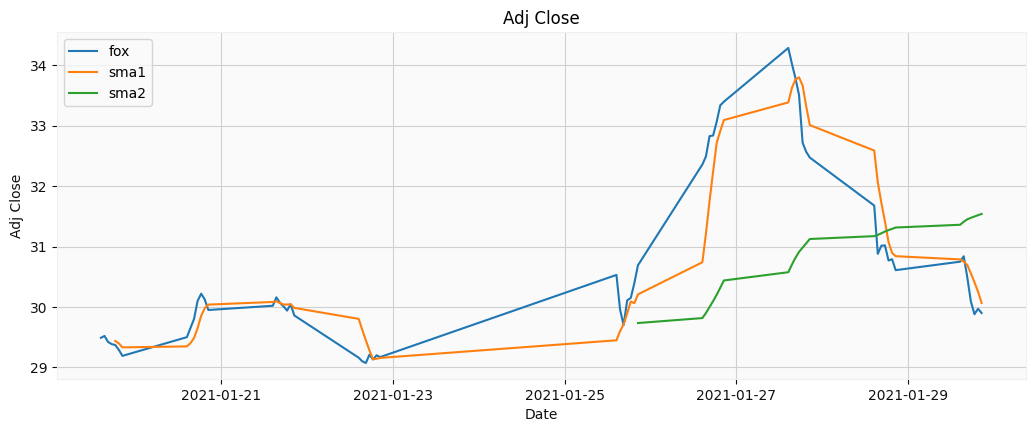

In [ ]:
#Visualize 
plt.figure(figsize=(12.5,4.5))
plt.plot(df['Adj Close'], label=ticker)
plt.plot(sma1['Adj Close'],label='sma1')
plt.plot(sma2['Adj Close'],label='sma2')
plt.title('Adj Close')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend(loc='upper left')
plt.savefig('{}_dou_sma.png'.format(ticker))
plt.show()

In [ ]:
#Create a new dataframe to store all the data
data = pd.DataFrame()
data['df'] = df['Adj Close']
data['SMA'+str(window1)] = sma1['Adj Close']
data['SMA'+str(window2)] = sma2['Adj Close']
data

,df,SMA5,SMA35
2021-01-19 09:30:00-05:00,29.490000,NaN,NaN
2021-01-19 10:30:00-05:00,29.520000,NaN,NaN
2021-01-19 11:30:00-05:00,29.420000,NaN,NaN
2021-01-19 12:30:00-05:00,29.385000,NaN,NaN
2021-01-19 13:30:00-05:00,29.370001,29.437,NaN
...,...,...,...
2021-01-29 11:30:00-05:00,30.490000,30.696,31.451743
2021-01-29 12:30:00-05:00,30.090000,30.556,31.476886
2021-01-29 13:30:00-05:00,29.879999,30.410,31.498314
2021-01-29 14:30:00-05:00,29.969999,30.254,31.520314


###Strategy

In [ ]:
#creat a function to signal when to buy and sell the stock 

def dualMACrossover(data):
    sigPriceBuy = []
    sigPriceSell = []
    flag = -1 # Flag denoting when the 2 moving averages crossed each other
    for i in range(len(data)):
        if data['SMA'+str(window1)][i] > data['SMA'+str(window2)][i]:
            if flag != 1:
                sigPriceBuy.append(data['df'][i])
                sigPriceSell.append(np.nan)
                flag = 1
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        elif data['SMA'+str(window1)][i] < data['SMA'+str(window2)][i]:
            if flag!=0:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(data['df'][i])
                flag=0
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        else:
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
    return (sigPriceBuy,sigPriceSell)

In [ ]:
#store the by and sell data into a variable
buy_sell = dualMACrossover(data)
data['BuySignalPrice'] = buy_sell[0]
data['SellSignalPrice'] = buy_sell[1]

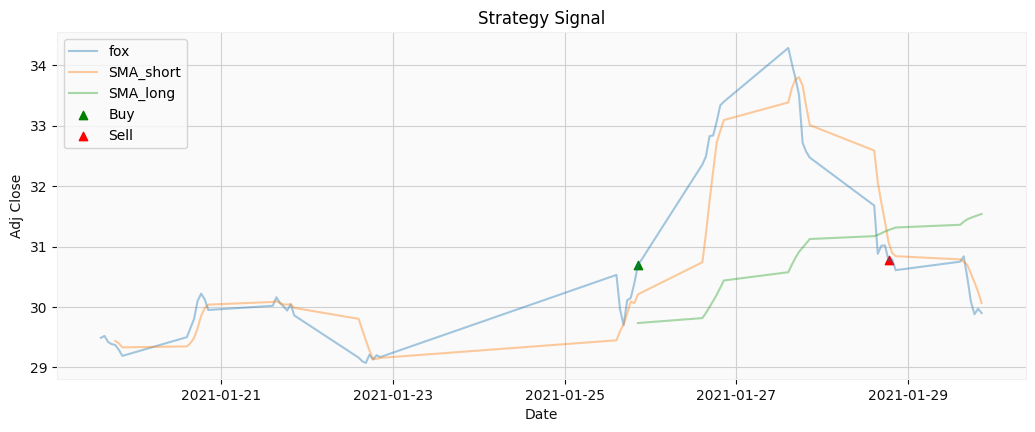

In [ ]:
#show the data and the strategy 
plt.figure(figsize=(12.5,4.5))
plt.plot(data['df'], label=ticker, alpha=0.4)
plt.plot(data['SMA5'], label="SMA_short", alpha=0.4)
plt.plot(data['SMA35'], label="SMA_long", alpha=0.4)
plt.scatter(data.index, data['BuySignalPrice'], label= 'Buy', marker='^',color='green')
plt.scatter(data.index, data['SellSignalPrice'], label= 'Sell', marker='^',color='red')
plt.title('Strategy Signal')
plt.xlabel('Date') 
plt.ylabel('Adj Close')
plt.legend(loc='upper left')
plt.savefig('{}_dou_signals.png'.format(ticker))
plt.show()

###Backtest

In [ ]:
#executing backtest
class DualMACrossover(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, window1)
        self.ma2 = self.I(SMA, price, window2)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()


In [ ]:
#execute the backtest and visualization
bt_dual = Backtest(df, DualMACrossover,
              exclusive_orders=True)
stats_dual = bt_dual.run()
bt_dual.plot(filename='{}_dou_backtest'.format(ticker))

In [ ]:
stats_dual['_equity_curve']

,Equity,DrawdownPct,DrawdownDuration
2021-01-19 09:30:00-05:00,10000.000000,0.000000,NaT
2021-01-19 10:30:00-05:00,10000.000000,0.000000,NaT
2021-01-19 11:30:00-05:00,10000.000000,0.000000,NaT
2021-01-19 12:30:00-05:00,10000.000000,0.000000,NaT
2021-01-19 13:30:00-05:00,10000.000000,0.000000,NaT
...,...,...,...
2021-01-29 11:30:00-05:00,10087.750149,0.000000,0 days 20:00:00
2021-01-29 12:30:00-05:00,10217.750025,0.000000,NaT
2021-01-29 13:30:00-05:00,10286.000347,0.000000,NaT
2021-01-29 14:30:00-05:00,10256.750298,0.002844,NaT


In [ ]:
#shows the trades
stats_dual['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,-325,54,62,30.76,29.959999,260.000372,0.026008,2021-01-28 14:30:00-05:00,2021-01-29 15:30:00-05:00,1 days 01:00:00


In [ ]:
dou_roi = (list(stats_dual['_equity_curve'].Equity)[-1]/list(stats_dual['_equity_curve'].Equity)[0])-1

##Buy and Hold

Maybe we have to put this also in backtesting library ( I started I wrote a buy function and a sell function we have to put them together in orther to be able to test them with backtrading.)

https://towardsdatascience.com/buy-and-hold-trading-strategy-66b4c3ac9b68

https://www.backtrader.com/blog/2019-06-13-buy-and-hold/buy-and-hold/

In [ ]:
#Simple strategy
class BuyAndHold_Buy(bt.Strategy):
    def start(self):
        # set the starting cash
        self.val_start = self.broker.get_cash() 
    def nextstart(self):
        # Buy stocks with all the available cash
        size = int(self.val_start / self.data)
        self.buy(size=size)
    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        print("ROI: %.2f, Cash: %.2f" % (100.0 * self.roi, self.broker.get_value()))

In [ ]:
# download the data since this library can only work whit the specific dataset
data = bt.feeds.YahooFinanceData(
    dataname=ticker.upper(), fromdate=datetime(2021,1,19), todate=datetime(2021, 1, 29)
)

In [ ]:
#rename the execution engine
cerebro = bt.Cerebro()

In [ ]:
#add the data
cerebro.adddata(data)

In [ ]:
#add the strategy
cerebro.addstrategy(BuyAndHold_Buy, "HODL")

0

In [ ]:
#add the tradable cash
cerebro.broker.setcash(10000.0)

In [ ]:
#add related sum cost
cerebro.broker.setcommission(commission=0.002)

In [ ]:
#run the backtest engine
cerebro.run()

ROI: 0.00, Cash: 10000.00


In [ ]:
bh_roi = (cerebro.broker.getvalue()/10000)-1

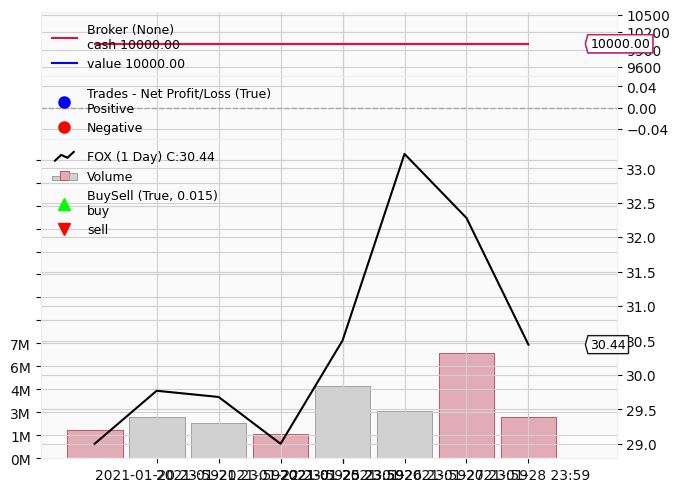

In [ ]:
#visualization
plot = cerebro.plot(iplot=False,savefig=True, figfilename='{}_bh_backtest.png'.format(ticker))[0][0]
plot.savefig('{}_bh_backtest.png'.format(ticker))

## Prediction based

In [ ]:
df = pd.read_csv("{}_predictions.csv".format(ticker), index_col=0)

### STD strategy

In [ ]:
for col in df.columns:
  df["change_{column}".format(column = col)] = df[col].diff()
df.iloc[:,4:8] = df.iloc[:,4:8].shift(-1)
df.dropna(inplace=True)

In [ ]:
std = df["label"].std()

In [ ]:
# making a small function that will let us assign the positions
def assign_sign_std(row):    
  if row > std:
      row = 1
  elif row < -std:
      row = -1
  else:
    row = 0
  return row

In [ ]:
# applying the function to daily differences
for col in df.columns[4:8]:
  df[col] = df[col].apply(lambda x: assign_sign_std(x))

### 2% strategy

In [ ]:
for col in df.columns[:4]:
  df["perc_change_{column}".format(column = col)] = df[col].pct_change()
df.iloc[:,8:12] = df.iloc[:,8:12].shift(-1)
df.dropna(inplace=True)

In [ ]:
# making a small function that will let us assign the positions
def assign_sign_perc(row):    
  if row > 0.02:
      row = 1
  elif row < -0.02:
      row = -1
  else:
    row = 0
  return row

In [ ]:
# applying the function to daily differences
for col in df.columns[8:]:
  df[col] = df[col].apply(lambda x: assign_sign_perc(x))

### Backtest

In [ ]:
df = df.iloc[:,[0,5,6,7,9,10,11]]

In [ ]:
for col in df.columns[1:]:

  positions = list(df[col])

  if positions[0] != -1:
    positions[0] = positions[0]*100
  else:
    positions[0] = 0

  for i, row in enumerate(positions[:-1]):
    if positions[i] + (positions[i+1]*100)>=0:
      positions[i+1] = positions[i]+(positions[i+1]*100)
    else:
      positions[i+1] = 0

  df["nshares_{}".format(col)]=positions

In [ ]:
for col in df.columns[1:7]:

  positions = list(df[col])
  values= list(df["nshares_{}".format(col)])
  price = list(df["label"])

  if positions[0] != 1:
    positions[0] = 1000000
  else:
    positions[0] = 1000000-price[0]*positions[0]*100*1.0015

  for i, row in enumerate(positions[:-1]):

    if (positions[i+1] == -1) and (values[i+1] == 0):
      positions[i+1] = positions[i]
    else:
      positions[i+1] = positions[i] - positions[i+1]*price[i+1]*100*1.0015

  df["money_{}".format(col)]=positions

In [ ]:
for col in df.columns[1:7]:
  money =  list(df["money_{}".format(col)])
  values= list(df["nshares_{}".format(col)])
  price = list(df["label"])
  total   =  money
  for i in range(len(df.label)):
    total[i]= money[i]+values[i]*price[i]
  df["total_{}".format(col)]=total

In [ ]:
df.iloc[:,-6:]

,total_change_text,total_change_tech,total_change_both,total_perc_change_text,total_perc_change_tech,total_perc_change_both
2021-01-19 09:30:00,1000000.0,1000000.0,1000000.0,1000000.000000,1000000.0,1000000.000000
2021-01-19 10:30:00,1000000.0,1000000.0,1000000.0,1000000.000000,1000000.0,1000000.000000
2021-01-19 11:30:00,1000000.0,1000000.0,1000000.0,1000000.000000,1000000.0,1000000.000000
2021-01-19 12:30:00,1000000.0,1000000.0,1000000.0,1000000.000000,1000000.0,1000000.000000
2021-01-19 13:30:00,1000000.0,1000000.0,1000000.0,999995.594500,1000000.0,999995.594500
...,...,...,...,...,...,...
2021-01-29 09:30:00,1000000.0,1000000.0,1000000.0,993630.537849,1000000.0,988055.504569
2021-01-29 10:30:00,1000000.0,1000000.0,1000000.0,993666.537910,1000000.0,988064.504584
2021-01-29 11:30:00,1000000.0,1000000.0,1000000.0,993526.537758,1000000.0,988029.504546
2021-01-29 12:30:00,1000000.0,1000000.0,1000000.0,993362.024410,1000000.0,987984.991084


In [ ]:
returns = df.iloc[:,-6:]

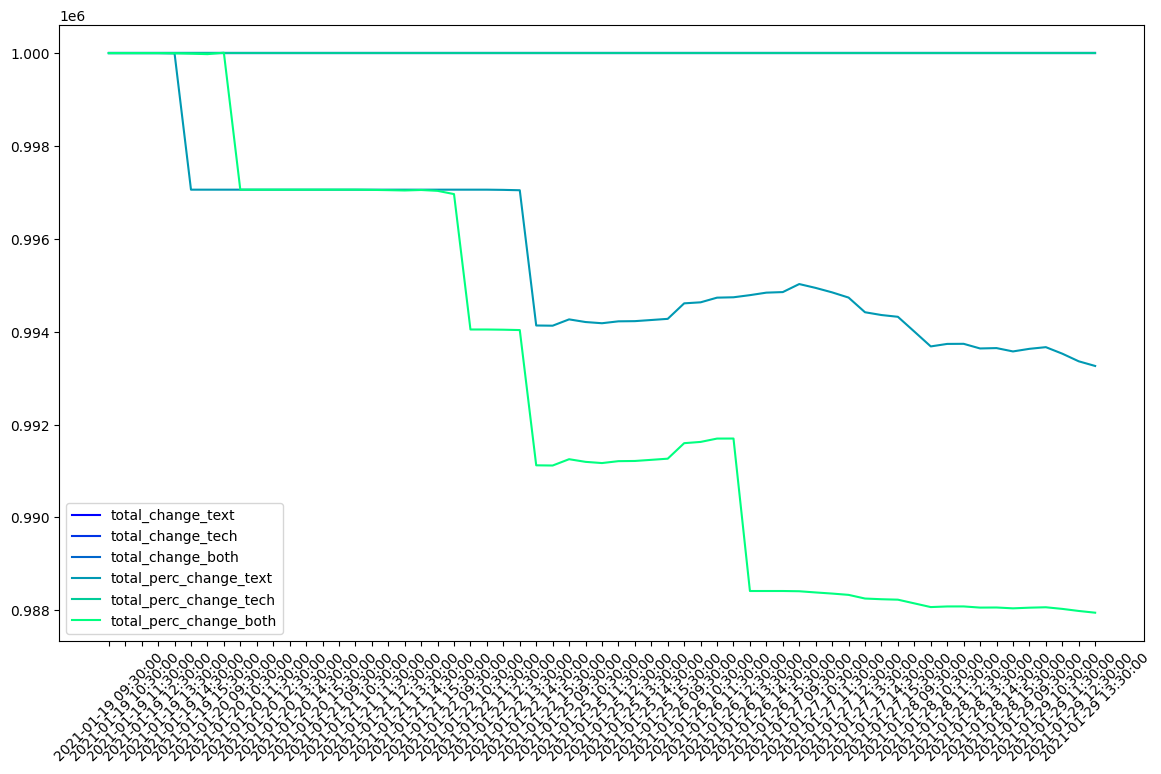

In [ ]:
# creating the visualization of daily returns for each appraoch
plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize=(14,8))
colors = plt.cm.winter(np.linspace(0,1,6))
plt.xticks(rotation=45)
for i in range(6):
  plt.plot(returns.iloc[:,i], color = colors[i])
plt.legend(returns.columns)
plt.savefig('{}_pred_backtest.png'.format(ticker))
plt.show()

In [ ]:
files.download('{}_prices_2.png'.format(ticker))
files.download('{}_prices_1.png'.format(ticker))
files.download('{}_sma_not_opt.html'.format(ticker))
files.download('{}_sma_opt.html'.format(ticker))
files.download('{}_dou_sma.png'.format(ticker))
files.download('{}_dou_signals.png'.format(ticker))
files.download('{}_dou_backtest.html'.format(ticker))
files.download('{}_bh_backtest.png'.format(ticker))
files.download('{}_pred_backtest.png'.format(ticker))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
d = {}
for col in returns.columns:  
  d["{}_roi".format(col)] = (list(returns[col])[-1]/list(returns[col])[0])-1
d["bh_roi"] = bh_roi
d["sma_roi"] = sma_roi
d["dou_roi"] = dou_roi

In [ ]:
d

{'bh_roi': 0.0,
 'dou_roi': 0.026000037193298242,
 'sma_roi': 0.12572582526588438,
 'total_change_both_roi': 0.0,
 'total_change_tech_roi': 0.0,
 'total_change_text_roi': 0.0,
 'total_perc_change_both_roi': -0.012052527114486677,
 'total_perc_change_tech_roi': 0.0,
 'total_perc_change_text_roi': -0.006738494085693381}

In [ ]:
backtest_results[ticker]=d.values()

# end loop

In [ ]:
backtest_results = backtest_results.sort_index(axis=1)
backtest_results.to_csv("backtest_results.csv")
files.download("backtest_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>